**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Aluna(o): 



---

Este notebook é parcialmente baseado no notebook **probability-4.ipynb**, disponível no portal AIMA Python, o qual foi referenciado no portal do curso na Plataforma Turing. O documento foi traduzido para o Português e algumas adaptações foram feitas.

# Teorema de Bayes

$$
P(A|B) = \frac{ P(B|A) . P(A))}{P(B)}
$$

## Teorema da Probabilidade Total

-  Se os eventos $A_{1}, A_{2}, ... , A_{n}$, são mutuamente exclusivos, com $\sum_{i=1}^{n} P(A_{i}) = 1  $:

$$
P(B) = \sum_{i=1}^{n}P(B|A_i)P(A_i)
$$

# Probabilidades e Redes Bayesianas

A teoria da probabilidade nos permite computar a probabilidade de certos eventos ocorrerem, feitas suposições sobre os componentes destes eventos. Uma **Rede Bayesiana** é uma estrutura de dados para representar a distribuição de probabilidades conjunta sobre várias variáveis aleatórias, e fazer inferências sobre elas.

Como exemplo, temos uma rede com cinco variáveis aleatórias, cada uma com sua **tabela de probabilidades condicionais** (TPC), com ligações dirigidas (setas) do nó pai para seus filhos. O problema, proposto por Judea Pearl, mostra uma casa onde foi instalado um alarme que dispara tanto em caso de ocorrência de roubo quanto de terremoto. Se o alarme dispara, um dos dois (ou ambos) os vizinhos, John e Mary podem ligar para o dono da casa e dizer que o alarme está tocando.

<p><img src="http://norvig.com/ipython/burglary2.jpg">

Esta rede bayesiana foi implementada com ajuda de sete classes Python:


## `BayesNet()`

 `BayesNet` é um grafo (como no diagrama acima) onde cada nó representa uma variável aleatória, e as arestas são ligações dos pais para os filhos.Pode-se construir um grafo vazio com `BayesNet()` e, então, acrescentar variáveis, uma a uma,  usando o método `.add(`*nome_da_variável, nomes_dos_pais, tpc*`)`, onde os nomes são strings, e cada um dos `nomes_dos_pais` deve ter sido incluído (com `.add`) previamente.
  
## `Variable(`*nome, tpc, pais*`)`

Uma variável aleatória é representada por uma oval, no diagrama anterior. O valor de cada variável depende do valor dos seus pais, na forma especificada pela tabela de probabilidades condicionais (TPC) para esta variável. Dados os pais de uma variável, ela é independente de todas as outras variáveis. Por exemplo, se eu sei que *Alarm* é *true* ou *false*, então eu sei qual é a probabilidade de *JohnCalls*, e evidências sobre as outras variáveis não me darão nenhuma outra informação sobre *JohnCalls*. Cada linha da TPC usa a mesma ordem de variáveis que a lista de pais. Iremos somente considerar  variáveis com domínio discreto e finito. Não consideraremos valores contínuos.
  

## `ProbDist(`*mapping*`)`

Uma distribuição de probabilidades é um mapeamento de  `{saída: probabilidade}`
para cada saída de uma variável aleatória. Você pode dar à  `ProbDist` os mesmos argumentos que você daria para o inicializador de um `dict`. Por exemplo: `ProbDist(sun=0.6, rain=0.1, cloudy=0.3)`.
Para simplificar, você pode dizer `ProbDist(0.95)` ao invés de `ProbDist({T: 0.95, F: 0.05})`.
  
Em uma distribuição de probabilidade, todo valor está entre 0 e 1, e a soma dos valores deve totalizar 1.

##`Factor(`*mapping*`)`
Um `Factor` é semelhante à uma distribuição de probabilidades, exceto que a soma dos valores não precisam totalizar 1. Factors são usados no método de inferência para eliminação de variáveis.


## `Evidence(`*mapping*`)`

É um mapeamento (*mapping*) de pares  `{Variável: valor, ...}` descrevendo os valores exatos para um conjunto de variáveis. Representa aquilo que temos certeza.
  

## `CPTable(`*linhas, pais*`)`

A tabela de probabilidades condicionais (TPC) descreve a probabilidade de cada valor possível de saída de uma variável aleatória, dados os valores das variáveis pais. A TPC é um mapeamento, `{tuple: probdist, ...}`, onde cada tupla lista os valores de cada uma das variáveis pais, em ordem, e cada distribuição de probabilidades diz quais são os possíveis valores de saída, dados os valores dos pais. A `CPTable` para  *Alarm* no diagrama acima poderia ser representada por:
  
    CPTable({(T, T): .95,
             (T, F): .94,
             (F, T): .29,
             (F, F): .001},
            [Burglary, Earthquake])
            
  
Como ler isso? A segunda linha, por exemplo, "`(T, F): .94`". Ela significa que, quando o primeiro pai (`Burglary`) é **true**, e o segundo pai  (`Earthquake`) é **false**, então a probabilidade de `Alarm` ser **true** é .94. Note que 0.94 é uma abreviação para `ProbDist({T: .94, F: .06})`.
          
T = Bool(True); F = Bool(False)

  Quando usamos os valores booleanos (`True` and `False`), fica mais difícil ler as linhas da TPC, por que as colunas não ficam alinhadas:
  
     (True, True, False, False, False)
     (False, False, False, False, True)
     (True, False, False, True, True)
 
  Sendo assim, criamos uma class  `Bool`, com as constantes `T` e `F` tal que  `T == True` and `F == False`. Desta forma, fica mais fácil ler as linhas:

     (T, T, F, F, F)
     (F, F, F, F, T)
     (T, F, F, T, T)
     
A seguir o código para estas classes.

In [44]:
from collections import defaultdict, Counter
import itertools
import math
import random

class BayesNet(object):
    "Uma rede bayesiana: um grafo de variáveis conectadas a seus pais por ligações"
     
    def __init__(self): 
        self.variables = [] # Lista de variáveis, ordenadas de acordo com a ocorrência de seus pais na topologia da rede
        self.lookup = {}    # Mapeamento de pares {variable_name: variable} 
            
    def add(self, name, parentnames, cpt):
        "Acrescenta uma nova variável a BayesNet. Os nomes dos pais devem ter sido acrescentados previamente"
        
        parents = [self.lookup[name] for name in parentnames] #variáveis pais
        #print('variável:',name)
        #print('parents:',parents)
        var = Variable(name, cpt, parents)
        self.variables.append(var)
        self.lookup[name] = var
        return self
    
class Variable(object):
    "Um variável aleatória; condicional em zero ou mais Variables pais"
        
    def __init__(self, name, cpt, parents=()):
        "Uma variável tem um nome, uma lista de variáveis pais, em uma TPC"
        
        self.__name__ = name
        self.parents  = parents
        self.cpt      = CPTable(cpt, parents)
        self.domain   = set(itertools.chain(*self.cpt.values())) # Todas as saídas na TPC
                
    def __repr__(self): return self.__name__
    
class Factor(dict): "Um mapeamento {outcome: frequency}."

class ProbDist(Factor):
    """Uma Distribuição de Probabilidades é um mapeamento {outcome: probability}
    Os valores são normalizados para ter soma igual a 1.
    ProbDist(0.75) é uma abreviação para ProbDist({T: 0.75, F: 0.25})."""
    def __init__(self, mapping=(), **kwargs): 
      # **kwargs fornece todos os 'keyword arguments' como um dicionário, exceto aqueles que são parâmetros formais
        if isinstance(mapping, float):
            mapping = {T: mapping, F: 1 - mapping}
        self.update(mapping, **kwargs)
        normalize(self)
        
class Evidence(dict): 
    "Um mapeamento {variable: value}, descrevendo o que sabemos com certeza."
            
class CPTable(dict):
    "Um mapeamento de {row: ProbDist, ...}, onde cada linha é uma tupla de valores de variáveis pais."
        
    def __init__(self, mapping, parents=()):
        """Provê dois atalhos para a escrita da TPC.
        Sem pais, CPTable(dist) means CPTable({(): dist}).
        Com pais, CPTable({val: dist,...}) means CPTable({(val,): dist,...})."""
        
        if len(parents) == 0 and not (isinstance(mapping, dict) and set(mapping.keys()) == {()}):
            mapping = {(): mapping}
        for (row, dist) in mapping.items():
            if len(parents) == 1 and not isinstance(row, tuple): 
                row = (row,)
            self[row] = ProbDist(dist)

class Bool(int):
    "O mesmo que `bool`, a não ser pelo fato de que os valores 'True' and 'False' são mostrados como'T' e 'F' " 
    __str__ = __repr__ = lambda self: 'T' if self else 'F'
        
T = Bool(True)
F = Bool(False)

A seguir, mais algumas funções associadas:

In [45]:
def P(var, evidence={}):
    "A distribuição de probabilidades para P(variável|evidência), quando todos as variáveis pais são conhecidas (em evidência)"
    
    row = tuple(evidence[parent] for parent in var.parents) # tupla: lista de valores separados por vírgulas. É imutável.
    return var.cpt[row]

def normalize(dist):
    "Normaliza uma distribuição  {key: value} de forma que a soma seja 1.0. Muda a distribuição e a retorna."
    
    total = sum(dist.values())
    for key in dist:
        dist[key] = dist[key] / total
        assert 0 <= dist[key] <= 1, "Probabilidades devem estar entre 0 e 1."
    return dist

def sample(probdist):
    "Pega uma amostra aleatória de uma distribuição de probabilidades."
    
    r = random.random() # r é um ponto aleatório na distribuição de probabilidades
    c = 0.0             # c é a probabilidade cumulativa das saídas vistas até agora
    for outcome in probdist:
        c += probdist[outcome]
        if r <= c:
            return outcome
        
def globalize(mapping):
    "Dado um mapeamento {nome: valor}, exporta todos os nomes para o namespace (escopo) `globals()`"
    globals().update(mapping)

# Uso simples

A seguir alguns exemplos de como usar as classes:

In [46]:
# Exemplo de variável aleatória: Earthquake.
# Um terremoto ocorre em 0.002 dias, independente de qualquer outra variável.

Earthquake = Variable('Earthquake', 0.002)

In [47]:
# A distribuição de probabilidade para Earthquake
P(Earthquake)

{F: 0.998, T: 0.002}

In [48]:
# Obtém a probabilidade para uma saída específica. Neste caso, a chave de acesso ao dicionário é 'T' 
P(Earthquake)[T]

0.002

In [49]:
# Pega uma amostra aleatória da distribuição
sample(P(Earthquake))

F

In [50]:
# Aleatoriamente, pela uma amostra 100.000 vezes, e conta os resultados:
Counter(sample(P(Earthquake)) for i in range(100000))

Counter({F: 99770, T: 230})

In [51]:
# Duas formas equivalentes de especificar a mesma distribuição de probabilidades booleanas
assert ProbDist(0.75) == ProbDist({T: 0.75, F: 0.25})

In [52]:
# Duas formas equivalentes de especificar a mesma distribuição de probabilidades não booleana
assert ProbDist(win=15, lose=3, tie=2) == ProbDist({'win': 15, 'lose': 3, 'tie': 2})
ProbDist(win=15, lose=3, tie=2)

{'lose': 0.15, 'tie': 0.1, 'win': 0.75}

In [53]:
# A diferença entre um Factor e uma ProbDist -- a ProbDist é normalizada
Factor(a=1, b=2, c=3, d=4)

{'a': 1, 'b': 2, 'c': 3, 'd': 4}

In [54]:
ProbDist(a=1, b=2, c=3, d=4)

{'a': 0.1, 'b': 0.2, 'c': 0.3, 'd': 0.4}

# Exemplo: rede bayesiana de alarme


Como definir uma rede bayesiana a partir do diagrama anterior:

In [55]:
alarm_net = (BayesNet()
    .add('Burglary', [], 0.001)
    .add('Earthquake', [], 0.002)
    .add('Alarm', ['Burglary', 'Earthquake'], {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001})
    .add('JohnCalls', ['Alarm'], {T: 0.90, F: 0.05})
    .add('MaryCalls', ['Alarm'], {T: 0.70, F: 0.01}))  

In [56]:
# Torna Burglary, Earthquake, etc.variáveis globais
globalize(alarm_net.lookup) 
alarm_net.variables

[Burglary, Earthquake, Alarm, JohnCalls, MaryCalls]

In [57]:
# Distribuição de probabilidades para Burglary
P(Burglary)

{F: 0.999, T: 0.001}

In [58]:
# Probabilidade do alarme disparar, dado que ocorreu assalto e não terremoto
P(Alarm, {Burglary: T, Earthquake: F})

{F: 0.06000000000000005, T: 0.94}

In [59]:
# De onde vem a linha (T, F) na TPC para Alarm
Alarm.cpt

{(F, F): {F: 0.999, T: 0.001},
 (F, T): {F: 0.71, T: 0.29},
 (T, F): {F: 0.06000000000000005, T: 0.94},
 (T, T): {F: 0.050000000000000044, T: 0.95}}

# Redes Bayesianas como Distribuição de Probabilidades Conjunta

Uma rede bayesiana é uma forma compacta de especificar uma **distribuição conjunta completa** sobre todas as variáveis em uma rede. Dado um conjunto de variáveis {*X*<sub>1</sub>, ..., *X*<sub>*n*</sub>}, a distribuição conjunta é:

$$
P(X_1 = x_1, ... X_n = x_n) = \prod_{i}P(X_i = x_i | pais(X_i))
$$

Para um rede com *n* variáveis, cada uma com *b* valores, 
existem *b<sup>n</sup>* linhas na TPC (por exemplo, um bilhão de linhas para 30 variáveis booleanas), o que torna impraticável criar explicitamente uma TPC para redes grandes. Para pequenas redes, a função `joint_distribution` cria a distribuiição, a qual pode ser interessante para ver, e pode ser usada para se realizar inferências.


In [60]:
def joint_distribution(net):
    "Dada uma rede bayesiana, cria uma distribuição conjunta sobre todas a variáveis."
    return ProbDist({row: prod(P_xi_given_parents(var, row, net)
                               for var in net.variables)
                     for row in all_rows(net)})

def all_rows(net): return itertools.product(*[var.domain for var in net.variables])

def P_xi_given_parents(var, row, net):
    "A probabilidade que var = xi, dados os valores na linha"
    dist = P(var, Evidence(zip(net.variables, row)))
    xi = row[net.variables.index(var)]
    return dist[xi]

def prod(numbers):
    "O produto dos números: prod([2, 3, 5]) == 30. Análogo à `sum([2, 3, 5]) == 10`."
    result = 1
    for x in numbers:
        result *= x
    return result

In [61]:
# Todas as linhas da TPC (2**5 == 32 linhas)
set(all_rows(alarm_net))

{(F, F, F, F, F),
 (F, F, F, F, T),
 (F, F, F, T, F),
 (F, F, F, T, T),
 (F, F, T, F, F),
 (F, F, T, F, T),
 (F, F, T, T, F),
 (F, F, T, T, T),
 (F, T, F, F, F),
 (F, T, F, F, T),
 (F, T, F, T, F),
 (F, T, F, T, T),
 (F, T, T, F, F),
 (F, T, T, F, T),
 (F, T, T, T, F),
 (F, T, T, T, T),
 (T, F, F, F, F),
 (T, F, F, F, T),
 (T, F, F, T, F),
 (T, F, F, T, T),
 (T, F, T, F, F),
 (T, F, T, F, T),
 (T, F, T, T, F),
 (T, F, T, T, T),
 (T, T, F, F, F),
 (T, T, F, F, T),
 (T, T, F, T, F),
 (T, T, F, T, T),
 (T, T, T, F, F),
 (T, T, T, F, T),
 (T, T, T, T, F),
 (T, T, T, T, T)}

In [62]:
# Vamos trabalhar com apenas uma linha da tabela:
row = (F, F, F, F, F)

In [63]:
# Esta é distribuição de probabilidades para Alarm
P(Alarm, {Burglary: F, Earthquake: F})

{F: 0.999, T: 0.001}

In [64]:
# Aqui está a probabilidade de Alarm ser falso, dados os valores para seus pais nesta linha:
P_xi_given_parents(Alarm, row, alarm_net)

0.999

In [65]:
# A distribuição conjunta completa:
joint_distribution(alarm_net)

{(F, F, F, F, F): 0.9367427006190001,
 (F, F, F, F, T): 0.009462047481000001,
 (F, F, F, T, F): 0.04930224740100002,
 (F, F, F, T, T): 0.0004980024990000002,
 (F, F, T, F, F): 2.9910060000000004e-05,
 (F, F, T, F, T): 6.979013999999999e-05,
 (F, F, T, T, F): 0.00026919054000000005,
 (F, F, T, T, T): 0.00062811126,
 (F, T, F, F, F): 0.0013341744900000002,
 (F, T, F, F, T): 1.3476510000000005e-05,
 (F, T, F, T, F): 7.021971000000001e-05,
 (F, T, F, T, T): 7.092900000000001e-07,
 (F, T, T, F, F): 1.7382600000000002e-05,
 (F, T, T, F, T): 4.0559399999999997e-05,
 (F, T, T, T, F): 0.00015644340000000006,
 (F, T, T, T, T): 0.00036503460000000007,
 (T, F, F, F, F): 5.631714000000006e-05,
 (T, F, F, F, T): 5.688600000000006e-07,
 (T, F, F, T, F): 2.9640600000000033e-06,
 (T, F, F, T, T): 2.9940000000000035e-08,
 (T, F, T, F, F): 2.8143600000000003e-05,
 (T, F, T, F, T): 6.56684e-05,
 (T, F, T, T, F): 0.0002532924000000001,
 (T, F, T, T, T): 0.0005910156000000001,
 (T, T, F, F, F): 9.4050000000

In [66]:
#Probabilidade de "o alarme soar, mas nem ter ocorrido roubo nem terremoto
# e nem John nem Mary ligarem ( na pág. 514 este valor deveria ser 0.000628)

print(alarm_net.variables)
joint_distribution(alarm_net)[F, F, T, T, T]

[Burglary, Earthquake, Alarm, JohnCalls, MaryCalls]


0.00062811126

# Inferência por consultas à Distribuição Conjunta

Podemos usar `P(variável, evidência)`para obter a probabilidade de uma variável, se soubermos os valores de todos os pais desta variável. Mas, e se não soubermos estes valores? As redes bayesianas nos permitem calcular a probabilidade, mas este cálculo não é apenas uma consulta à uma TPC; é um cálculo global que deve ser realizado por toda a rede. Uma forma ineficiente, mas simples de realizar este cálculo é criar uma distribuição de probabilidades conjunta, então pegar somente as linhas que correspondam às variáveis das evidências, e para cada linha verificar qual é valor da variável da consulta e incrementar a probabilidade para este valor adequadamente. 



In [67]:
def enumeration_ask(X, evidence, net):
    "A distribuição de probabilidade para a variável X da consulta na rede de crenças, dadas as evidências"
    i    = net.variables.index(X) # O índice da variável X da consulta na linha
    dist = defaultdict(float)     # O resultado da distribuição de probabilidades sobre X
    for (row, p) in joint_distribution(net).items():
        if matches_evidence(row, evidence, net):
            dist[row[i]] += p
    return ProbDist(dist)

def matches_evidence(row, evidence, net):
    "A tupla de valores para esta linha está de acordo com a evidência?"
    return all(evidence[v] == row[net.variables.index(v)]
               for v in evidence)

In [68]:
# A probabilidade de roubo (Burglary), dado que John liga, mas Maria não:
enumeration_ask(Burglary, {JohnCalls: F, MaryCalls: T}, alarm_net)

{F: 0.9931237539265789, T: 0.006876246073421024}

In [69]:
# A probabilidade de o alarm soar (Alarm), dado que ocorreu um terremoto (Earthquake) e Mary liga:
enumeration_ask(Alarm, {MaryCalls: T, Earthquake: T}, alarm_net)

{F: 0.03368899586522123, T: 0.9663110041347788}

# Eliminação de variáveis

O algoritmo `enumeration_ask`consome tempo e espaço que é exponencial com relação ao número de variáveis. Isto é, primeiro ele cria a distribuição conjunta, de tamanho *b<sup>n</sup>*, e depois ele soma os valores para as linhas correspondentes à evidência. Podemos fazer melhor que isto se intercalarmos a conjunção de variáveis com o somatório dos valores. Esta abordagem é chamada de *eliminação de variáveis*. A idéia é que quando computamos $P(X_1 = x_1, ... X_n = x_n) = \prod_{i}P(X_i = x_i | pais(X_i))$, nós estamos repetindo o cálculo de $P(X_3 = x_3 | pais(X_3))$ múltiplas vezes, através de múltiplas linhas da distribuição conjunta.



In [70]:
# A ser feito: copiar e atualizar o algoritmo de eliminação de variáveis e também os algoritmos de amostragem.

# Exemplo: rede da gripe


Nesta rede,  um paciente pegar uma gripe depende se ele foi vacinado,  e se pegar uma gripe influencia em ele ter febre ou dor de cabeça. Febre (`Fever`) é uma variável não booleana, com três valores, `no`, `mild`, e `high`.

In [71]:
flu_net = (BayesNet()
           .add('Vaccinated', [], 0.60)
           .add('Flu', ['Vaccinated'], {T: 0.002, F: 0.02})
           .add('Fever', ['Flu'], {T: ProbDist(no=25, mild=25, high=50),
                                   F: ProbDist(no=97, mild=2, high=1)})
           .add('Headache', ['Flu'], {T: 0.5,   F: 0.03}))

globalize(flu_net.lookup)

In [72]:
# Se você tem só dor de cabeça (headache), você provavelmente não tem gripe (Flu).
enumeration_ask(Flu, {Headache: T, Fever: 'no'}, flu_net)

{F: 0.9616440110625343, T: 0.03835598893746573}

In [73]:
# Ainda mais se você foi vacinado. 
enumeration_ask(Flu, {Headache: T, Fever: 'no', Vaccinated: T}, flu_net)

{F: 0.9914651882096696, T: 0.008534811790330398}

In [74]:
# Mas, se você não foi vacinado, há uma grande chance de você ter gripe.
enumeration_ask(Flu, {Headache: T, Fever: 'no', Vaccinated: F}, flu_net)

{F: 0.9194016377587209, T: 0.08059836224127925}

In [75]:
# E se você tem dor de cabeça e também febre, e não foi vacinado,
# então a gripe é bastante provável, especialmente se a febre for alta.
enumeration_ask(Flu, {Headache: T, Fever: 'mild', Vaccinated: F}, flu_net)

{F: 0.19041450777202068, T: 0.8095854922279793}

In [76]:
enumeration_ask(Flu, {Headache: T, Fever: 'high', Vaccinated: F}, flu_net)

{F: 0.05553456743483188, T: 0.9444654325651682}

# Entropia

Podemos computar a entropia da distribuição de probabilidades:

In [77]:
def entropy(probdist):
    "A entropia da distribuição de probabilidades."
    return - sum(p * math.log(p, 2)
                 for p in probdist.values())

In [78]:
entropy(ProbDist(heads=0.5, tails=0.5))

1.0

In [79]:
entropy(ProbDist(yes=1000, no=1))

0.011397802630112312

In [80]:
entropy(P(Alarm, {Earthquake: T, Burglary: F}))

0.8687212463394045

In [81]:
entropy(P(Alarm, {Earthquake: F, Burglary: F}))

0.011407757737461138

Para variáveis não booleanas, a entropia pode ser maior que 1 bit:

In [82]:
entropy(P(Fever, {Flu: T}))

1.5

# Saídas desconhecidas: Suavização (*Smoothing*)

Até agora nós lidamos com distribuições discretas onde sabíamos a priori todas as possíveis saídas . Para variáveis booleanas, as únicas saídas possíveis eram 'T' ou 'F'. Para `Fever`,  nós modelamos exatamente 3 saídas. Entretanto, em algumas aplicações, nós encontraremos novos valores que não são conhecidos a priori. Por exemplo, podemos treinar um modelo sobre a distribuição de palavras no Inglês, e então alguém poderia cunhar uma nova palavra. Para lidar com isto, nós introduzimos a distribuição `DefaultProbDist`. que usa a chave `None` para indicar qualquer saída desconhecida.



In [83]:
class DefaultProbDist(ProbDist):
    """Uma distribuição de probabilidades que suporta suavização para saídas desconhecidas (chaves).
    O valor padrão representa a probabilidade de uma chave desconhecida (não vista previamente).
    A chave 'None' indica uma saída desconhecida."""
    def __init__(self, default_value, mapping=(), **kwargs):
        self[None] = default_value
        self.update(mapping, **kwargs)
        normalize(self)
        
    def __missing__(self, key): return self[None]        

In [84]:
import re

def words(text): return re.findall(r'\w+', text.lower())

english = words('''This is a sample corpus of English prose. To get a better model, we would train on much
more text. But this should give you an idea of the process. So far we have dealt with discrete 
distributions where we  know all the possible outcomes in advance. For Boolean variables, the only 
outcomes are T and F. For Fever, we modeled exactly three outcomes. However, in some applications we 
will encounter new, previously unknown outcomes over time. For example, when we could train a model on the 
words in this text, we get a distribution, but somebody could coin a brand new word. To deal with this, 
we introduce the DefaultProbDist distribution, which uses the key `None` to stand as a placeholder for any 
unknown outcomes. Probability theory allows us to compute the likelihood of certain events, given 
assumptions about the components of the event. A Bayesian network, or Bayes net for short, is a data 
structure to represent a joint probability distribution over several random variables, and do inference on it.''')

E = DefaultProbDist(0.1, Counter(english))

In [85]:
# A palavra 'the' é comumun:
E['the']

0.052295177222545036

In [86]:
# A palavra 'possible' é menos comum
E['possible']

0.005810575246949448

In [87]:
# A palavra 'impossible' não foi vista nos dados de treinamento, mas ainda assim tem uma probabilidade diferente de zero
E['impossible']

0.0005810575246949449

In [88]:
# ... uma outra palavra rara e não vista previamente:
E['llanfairpwllgwyngyll']

0.0005810575246949449

Note que isto não significa que 'impossible',  'llanfairpwllgwyngyll' e todas as outras palavras tem *cada uma* probabilidade igual a 0.004.

Ao contrário, isto significa que todas as palavras desconhecidas totalizam uma probabilidade 0.004.  Com esta interpretação, a soma de todas as probabilidades ainda é 1, como deveria ser. Na `DefaultProbDist`, as palavras desconhecidas são todas representadas por 'None'.



In [89]:
E[None]

0.0005810575246949449

# Classificador bayesiano ótimo

-    Hipóteses falsas tendem a desaparecer
-    Espaço de hipóteses muito grande ou infinito

Considerando que D seja uma variável randômica, que $h_i$ seja uma hipótese do conjunto de hipótes H, e que  $e_j$ seja um exemplo do conjunto de exemplos E:

$$
P(e_j|D) = \sum_{h_i \in H}P(e_j|h_i)P(h_i/D)
$$

Então, um classificador bayesiano ótimo, pode ser definido por:

$$
\sum_{h_i \in H}P(e_j . h_i)P(h_i . D)
$$

# Classificador bayesiano ingênuo (naïve classifier)

-   Quando usá-lo:

   -   Quando estiver disponível um conjunto de treinamento médio ou grande
   -   Os atributos que descrevem as instâncias forem condicionalmente independentes dada uma classificação

-    Pode ser aplicado em tarefas de aprendizagem onde:
    -  cada instância x é descrita por uma conjunção de valores de atributos.
    -  a função alvo f(x) pode assumir qualquer valor de um conjunto V.
    -  um conjunto de exemplos de treinamento da função alvo é fornecido.
    -  uma nova instância é descrita pela tupla de valores de atributos  a_1, a_2, ..., a_n.
  
-    A tarefa é predizer o valor alvo (ou classe) para esta nova instância.

O algoritmo para o classificador bayesiano ingênuo envolve:

-    Uma fase de aprendizagem: os termos $P(e_j)$ e $P(a_i|e_j)$ são estimados com  base nas suas frequências no conjunto de treinamento.
-    Estas probabilidades "aprendidas" são usadas para classificar novas instâncias.

Se temos as variáveis independentes $a_1, a_2, ..., a_3$, então:

$$
P(a_1,...,a_n|e_j) = \prod_{i}P(a_i|e_j)
$$

Então, temos um classificador (Naïve Bayes - NB):

$$
P(e_j)\prod_{i}P(a_i . e_j)
$$

## Exemplo:

Um conjunto de documentos pode ser classificado em duas classes $v_j$: {"spam", "não spam"}

-  As variáveis $a_1, a_2, ..., a_n$ representam as palavras de um vocabulátio e $P'(a_i|v_j)$ é a frequência  com que a palavra $a_i$ aparece entre os documentos da classe $v_j$.
-  $P(v_j) = \frac {ND v_y}{ND}$, onde ${ND v_y}$ é número de documentos da classe $v_j$ e ND é o número total de documentos.

### Pelo teorema de Bayes:

-  Considerando uma variável de classe y, e um vetor de características dependentes  $𝑥_1,...,𝑥_𝑛$

$$
P(y|x_1, ... x_n) = \frac{P(y) . P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}
$$

-  Considerando a independência condicional das variáveis:

$$
P(x_i|y, x_1, ..., x_{i-1}, x_{i+1}, ... x_n) = P(x_i|y)
$$

-   Simplificando (para todo i):

$$
P(y|x_1,...,x_n) = \frac {P(y) \prod_{i=1}^n P(x_i|y)}{p(x_1, ..., x_n)}
$$

Como o denominador dessa fração é uma constante, uma vez dadas as entradas, pode-se dizer que:

$$
P(y|x_1,...,x_n) P(y) \varpropto  \prod_{i=1}^n P(x_i|y)
$$

Podemos usar a Estimação Máxima a Posteriori (MAP) para estimar P(y) e $P(x_i|y)$, obtendo então a frequência relativa da classe **y** no conjunto de treinamento:

$$
ŷ = arg max_y P(y) \prod_{i=1}^n P(x_i|y)
$$

Os diferentes classificadores bayesianos diferem apenas nas suposições feitas com relação à distribuição de $P(x_i|y)$.

### Exemplo: jogar ou não tênis

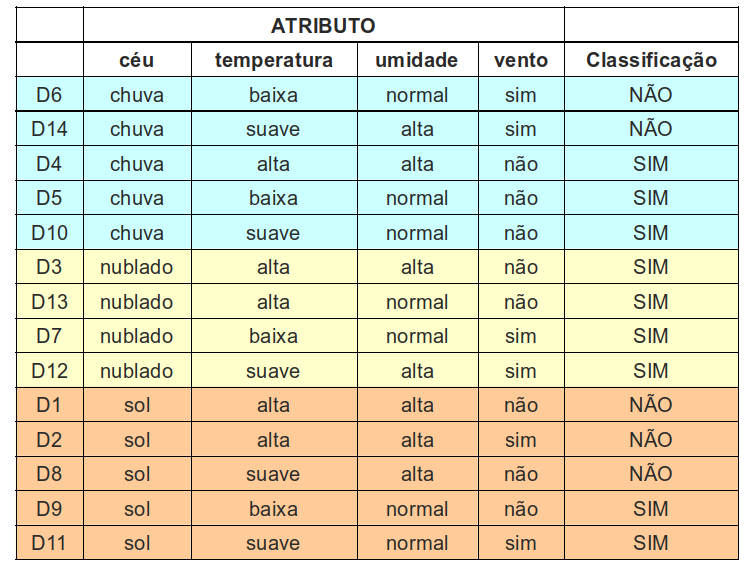

# Mais um exemplo:
Extraído de [Python Data Science Handbook ](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html)

### Classificação de textos

Obtendo os dados: mensagens em grupos de notícias

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [94]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Escolhendo apenas algumas categorias:

In [95]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Visualizando uma amostra dos dados:

In [100]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Convertendo as strings para um vetor de números, a fim de podermos usá-las no algoritmo de ML:

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Treinando o modelo:

In [102]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

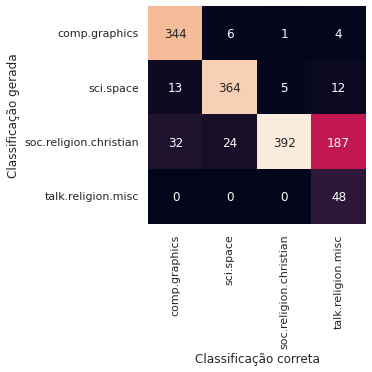

In [103]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('Classificação correta')
plt.ylabel('Classificação gerada');

In [104]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [105]:
predict_category('sending a payload to the ISS')

'sci.space'

In [106]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [107]:
predict_category('determining the screen resolution')

'comp.graphics'

In [108]:
predict_category('pray for christ')

'soc.religion.christian'

In [110]:
predict_category('the captain of interprise')

'sci.space'

In [111]:
predict_category('how are the klingons in star trek')

'sci.space'

In [112]:
predict_category('say something about herodes')

'soc.religion.christian'